In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
from keras import metrics
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys, os
import matplotlib.pyplot as plt

sys.path.append('../')


from preprocessing import TextConversion, DimensionalityReduction

2022-06-20 20:16:12.720349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-20 20:16:12.720371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/jade/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jade/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jade/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jade/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
df = pd.read_csv('../product_sentiment.csv')
df.head()

,index,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


4 fields available. The main text column (tweet_text) which will be the corpus for the model and the sentiment column (is_there_an_emotion_directed_at_a_brand_or_product) which will be used as the response variable. The product column (emotion_in_tweet_is_directed_at) gives us additional data which we can use to coax more information about the tweets.

In [6]:
df.shape

(9093, 4)

We have 9093 tweets to start with.

In [7]:
df.isnull().sum()

index                                                    0
tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

Two columns contain missing data. The products column has a majority of missing data (64%) while the tweets have only one missing value. So let's remove the row where the tweet is missing since this can't be used in this analysis anyway.

In [8]:
df_missing_removed = df[~df.tweet_text.isnull()]
df_missing_removed.shape

(9092, 4)

In [9]:
df.emotion_in_tweet_is_directed_at.value_counts(dropna=False)

NaN                                5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

<AxesSubplot:>

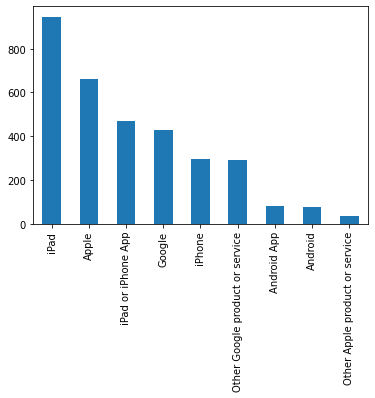

In [11]:
df.emotion_in_tweet_is_directed_at.value_counts().plot(kind='bar')

<AxesSubplot:>

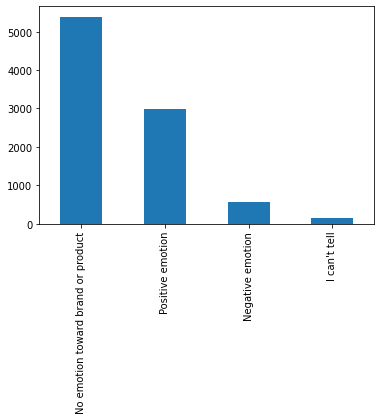

In [12]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False).plot(kind='bar')

There are 4 values in the sentiment column. 1 of which means inconclusive. In this instance, we will remove it since it cannot be used to validate / classify the data in line with the request. The remaining three give us a multiclass problem; positive, negative and neutral. As with many real world scenarios, we have unbalanced classes with the negative emotions being the minority, the neutral being the majority. 

Balance the classes or weight the metrics? 

There are other techniques we can use to give more context/ information to the sentiment of the text such as identifying subjectivity/ objectivity and sarcasm detection, however given the size of the dataset, there would not be much benefit from using these techniques.

In [4]:
df.duplicated().sum()

0

> Index 6 missing

> Drop missing values from tweet texts since this is themain source of information we're looking for

> No missing sentiments

> No duplicates

In [5]:
print([x for x in df.tweet_text[32:50]])

['Attn: All  #SXSW frineds, @mention Register for #GDGTLive  and see Cobra iRadar for Android. {link}', 'Anyone at  #sxsw want to sell their old iPad?', 'Anyone at  #SXSW who bought the new iPad want to sell their older iPad to me?', 'At #sxsw.  Oooh. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link}', 'The best!  RT @mention Ha! First in line for #ipad2 at #sxsw &quot;pop-up&quot; Apple store was an event planner #eventprofs #pcma #engage365', 'SPIN Play - a new concept in music discovery for your iPad from @mention &amp; spin.com {link} #iTunes #sxsw @mention', '@mention  - False Alarm: Google Circles Not Coming Now\x89ÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW', 'VatorNews - Google And Apple Force Print Media to Evolve? {link} #sxsw', '@mention  - Great weather to greet you for #sxsw! Still need a sweater at night..Apple putting up &quot;flash store&quot; downtown to sell iPad2', 'HootSuite - HootSuite Mobile for #SXSW 

In [16]:
No emoticons in this text


> Since we haven't got much data, the decision to lemmatise will leave us with a bigger pool of terms to weight on

> Not all mentions removed




In [3]:
dim_red = DimensionalityReduction()
txt_con = TextConversion()

In [117]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna = False)

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [116]:
df.emotion_in_tweet_is_directed_at.value_counts(dropna=False)

NaN                                5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [4]:
#DATA_FILE_PATH = '../data/crowdflower-brands-and-product-emotions/data/'
#TOKENIZED_DATA_FILE_NAME = 'tokenized_twitter_data.csv'
#pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42
MODEL_FILE_PATH = '../'
MODEL_FILE_NAME = 'emb_model_01_best_model.h5'
RUN_MODEL = False

In [5]:
dim_red = DimensionalityReduction()
txt_con = TextConversion()

(9093, 4) (8937, 4)


In [ ]:
for idx, sentence in enumerate(df_dropna.tweet_text):
    if idx%100 == 0:
        print(idx)
    
    if sentence == sentence:
        sentence_w_emoticons = txt_con.convert_emoticons(sentence)
        sentence_w_std_refs_rm = dim_red.remove_standardised_references(sentence_w_emoticons)
        sentence_lwr = txt_con.convert_sentence_to_lowercase(sentence_w_std_refs_rm)
        word_tokens = txt_con.tokenise_text(sentence_lwr)
        work_tokens_lmtzd = txt_con.text_lemmatisation(word_tokens)
        word_tokens_rm_punct = dim_red.remove_stopwords(work_tokens_lmtzd)
        word_tokens_rm_sngl_use_wrds = dim_red.remove_single_use_words(word_tokens_rm_punct)
        word_tokens_rm_punct = dim_red.remove_punctuation(word_tokens_rm_sngl_use_wrds)
        df_dropna.loc[idx, 'tweet_text_clean'] = ' '.join(x for x in word_tokens_rm_punct)
    else:
        print(sentence)
    
df_dropna.head()

In [34]:
import time

In [88]:
start = time.time()
#df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(txt_con.convert_emoticons)
#end_con_emots = time.time()
#print('converting emoticons', end_con_emots - start)
df_unk_removed = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
#df_unk_removed = df_unk_removed[df_unk_removed['is_there_an_emotion_directed_at_a_brand_or_product'] != "No emotion toward brand or product"]
print(df.shape, df_unk_removed.shape)
#df_missing_removed = df_unk_removed[~df_unk_removed.tweet_text.isnull()]
df_missing_removed = df_unk_removed.dropna(subset=['tweet_text'])
df_dropna = df_missing_removed
dim_red.generate_single_use_word_list(df.tweet_text.astype('str'))

df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(dim_red.remove_standardised_references)
end_std_refs = time.time()
print('Removing standard refs', end_std_refs - start)

df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(txt_con.convert_sentence_to_lowercase)
end_con_lwr = time.time()
print('Converting to lowercase', end_con_lwr - end_std_refs)


df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(txt_con.tokenise_text)
end_tokenize = time.time()
print('Tokenising texts', end_tokenize - end_con_lwr)


df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(txt_con.text_lemmatisation)
end_lmtze = time.time()
print('Text Lemmatisation', end_lmtze - end_tokenize)


df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(dim_red.remove_stopwords)
end_stpwords = time.time()
print('Removing stopwords', end_stpwords - end_lmtze)


df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(dim_red.remove_single_use_words)
end_sngl_words = time.time()
print('Removing single use words', end_sngl_words - end_stpwords)


df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(dim_red.remove_punctuation)
end_rmv_punct = time.time()
print('Removing punctuation', end_rmv_punct - end_sngl_words)

print('Joining')
df_dropna.loc[:, 'tweet_text_clean'] = df_dropna.tweet_text.apply(lambda x: ' '.join(w for w in x))

(9093, 4) (8937, 4)


/tmp/ipykernel_345830/1513908503.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(dim_red.remove_standardised_references)
/tmp/ipykernel_345830/1513908503.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(txt_con.convert_sentence_to_lowercase)


Removing standard refs 0.6482663154602051
Converting to lowercase 0.013913869857788086


/tmp/ipykernel_345830/1513908503.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(txt_con.tokenise_text)


Tokenising texts 0.9190833568572998
Text Lemmatisation 4.812535285949707
Removing stopwords 0.03372550010681152
Removing single use words 0.04976677894592285
Removing punctuation 0.0719764232635498
Joining


/tmp/ipykernel_345830/1513908503.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(txt_con.text_lemmatisation)
/tmp/ipykernel_345830/1513908503.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.loc[:, 'tweet_text'] = df_dropna['tweet_text'].apply(dim_red.remove_stopwords)
/tmp/ipykernel_345830/1513908503.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [ ]:
## missing data
## duplicates
## class balances

## By sentiment visualisation
## By product visualisation
## By length of text
## By length of text with polarity

## Remember that tweets are 140 characters

In [15]:
df_missing_removed.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna = False)

Positive emotion    2978
NaN                 2096
Negative emotion     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [16]:
df_missing_removed.isnull().sum()


index                                                 2096
tweet_text                                            2096
emotion_in_tweet_is_directed_at                       2453
is_there_an_emotion_directed_at_a_brand_or_product    2096
tweet_text_clean                                      2096
dtype: int64

In [17]:
df_missing_removed.isnull().sum()


index                                                 2096
tweet_text                                            2096
emotion_in_tweet_is_directed_at                       2453
is_there_an_emotion_directed_at_a_brand_or_product    2096
tweet_text_clean                                      2096
dtype: int64

In [19]:
df_input['emotion_in_tweet_is_directed_at'].value_counts(dropna=False)

iPad                               918
Apple                              638
iPad or iPhone App                 460
Google                             414
UNK                                357
iPhone                             287
Other Google product or service    283
Android App                         80
Android                             77
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [89]:
#DATA_FILE_PATH = '../'
#TOKENIZED_DATA_FILE_NAME = 'tokenized_twitter_data.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42
MODEL_FILE_PATH = 'models/'
MODEL_FILE_NAME = 'emb_model_01_best_model.h5'
RUN_MODEL = True

In [90]:
df_dropna.loc[:,'emotion_in_tweet_is_directed_at'] = df_missing_removed['emotion_in_tweet_is_directed_at'].apply(lambda x: 'UNK' if x != x else x)
df_input = df_dropna.dropna(subset=['tweet_text_clean', 'is_there_an_emotion_directed_at_a_brand_or_product', 'emotion_in_tweet_is_directed_at'])

/tmp/ipykernel_345830/2540411397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.loc[:,'emotion_in_tweet_is_directed_at'] = df_missing_removed['emotion_in_tweet_is_directed_at'].apply(lambda x: 'UNK' if x != x else x)


In [91]:

X_train, X_test, y_train, y_test = train_test_split(df_input['tweet_text_clean'], 
                                                    df_input['is_there_an_emotion_directed_at_a_brand_or_product'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE)
                                                   #stratify = df_input['is_there_an_emotion_directed_at_a_brand_or_product'])


# Set Max number of tokens per tweet
MAX_TOKENS = 30
# Set Max number of words/tokens in the corpus
NUM_WORDS = 5000


tokenizer = Tokenizer(num_words=NUM_WORDS, filters='', lower=False, split=' ')

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq_pad = pad_sequences(X_train_seq, padding='post', maxlen=MAX_TOKENS)
X_test_seq_pad = pad_sequences(X_test_seq, padding='post', maxlen=MAX_TOKENS)
print(len(X_train_seq_pad), len(X_train_seq_pad[0]))
print(len(X_test_seq_pad), len(X_test_seq_pad[0]))

## Encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

y_test_enc = le.transform(y_test)

y_train_oh = to_categorical(y_train_enc)
y_test_oh = to_categorical(y_test_enc)

## Validation set
X_train_emb, X_val_emb, y_train_emb, y_val_emb = train_test_split(X_train_seq_pad, 
                                                                y_train_oh, 
                                                                test_size=0.1, 
                                                                random_state=RANDOM_STATE)
print(len(X_train_emb), len(X_train_emb[0]))
print(len(y_train_emb), len(y_train_emb[0]))
print(len(X_val_emb), len(X_val_emb[0]))


## Setup Model
emb_model = models.Sequential()
emb_model.add(layers.Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=MAX_TOKENS))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(3, activation='softmax'))
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


save_best = ModelCheckpoint(os.path.join(MODEL_FILE_PATH,MODEL_FILE_NAME), 
                    monitor='val_categorical_accuracy', 
                    mode='max', 
                    verbose=1, 
                    save_best_only=True)




7148 30
1788 30
6433 30
6433 3
715 30


In [92]:
emb_model.compile(loss='categorical_crossentropy', 
                optimizer='nadam', 
                metrics=[metrics.categorical_accuracy])


if RUN_MODEL:
    emb_model_results = emb_model.fit(X_train_emb, 
                                    y_train_emb, 
                                    validation_data=(X_val_emb, y_val_emb), 
                                    epochs=20,
                                    callbacks=[early_stopping, save_best])

Epoch 1/20
195/202 [===========================>..] - ETA: 0s - loss: 0.8444 - categorical_accuracy: 0.6064
Epoch 1: val_categorical_accuracy improved from -inf to 0.61958, saving model to models/emb_model_01_best_model.h5
202/202 [==============================] - 1s 4ms/step - loss: 0.8430 - categorical_accuracy: 0.6053 - val_loss: 0.8381 - val_categorical_accuracy: 0.6196
Epoch 2/20
187/202 [==========================>...] - ETA: 0s - loss: 0.7270 - categorical_accuracy: 0.6880
Epoch 2: val_categorical_accuracy improved from 0.61958 to 0.63636, saving model to models/emb_model_01_best_model.h5
202/202 [==============================] - 1s 3ms/step - loss: 0.7237 - categorical_accuracy: 0.6899 - val_loss: 0.7795 - val_categorical_accuracy: 0.6364
Epoch 3/20
198/202 [============================>.] - ETA: 0s - loss: 0.5862 - categorical_accuracy: 0.7710
Epoch 3: val_categorical_accuracy improved from 0.63636 to 0.64336, saving model to models/emb_model_01_best_model.h5
202/202 [======

In [93]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_categorical_accuracy'])
    plt.plot(history['categorical_accuracy'])
    plt.legend(['val_categorical_accuracy', 'categorical_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

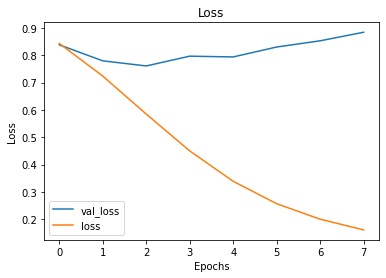

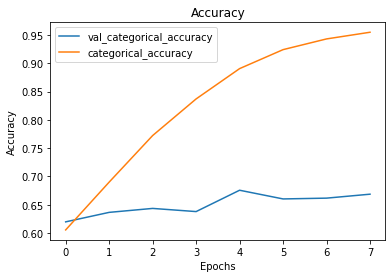

In [94]:
visualize_training_results(emb_model_results)

In [95]:
saved_model = load_model(MODEL_FILE_PATH+MODEL_FILE_NAME)

In [99]:
y_hat = saved_model.predict_classes(X_test_seq_pad)

results = saved_model.evaluate(X_test_seq_pad, y_test_oh)

print(classification_report(y_test_enc, np.argmax(y_hat, axis=1), target_names=le.classes_))

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [97]:
X_test = ['#sxsw oooh rt google launch major new social network call circle possibly today']

X_test_seq = tokenizer.texts_to_sequences(X_test)

X_test_seq_pad = pad_sequences(X_test_seq, padding='post', maxlen=MAX_TOKENS)

y_hat = saved_model.predict(X_test_seq_pad)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [70]:
print(y_hat)

[[0.04118243 0.71401304 0.24480456]]
